<H1>ANLY 590 Homework Assignment 1</H1>
<H3>Boyang Wei</H3>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.linear_model import LassoCV

In [2]:
#Load data
df = pd.read_csv('Hitters.csv')

#Remove NAs
df = df.dropna()

In [3]:
#Retain only numerical columns 
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df_numeric = df.select_dtypes(include=numerics)
df_numeric.head(5)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10,475.0
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14,480.0
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,200,11,3,500.0
4,321,87,10,39,42,30,2,396,101,12,48,46,33,805,40,4,91.5
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,282,421,25,750.0


In [4]:
#Split X and Y (Predictors and Response)
X_col = df_numeric.drop(['Salary'], axis=1)
y = df_numeric[['Salary']]

#Standardize data
nameList = list(X_col)
X = preprocessing.normalize(X_col)

<H3>LASSO Regression</H3>

<H4>visualization of the coeffcient trajectories of all predictors</H4>

.

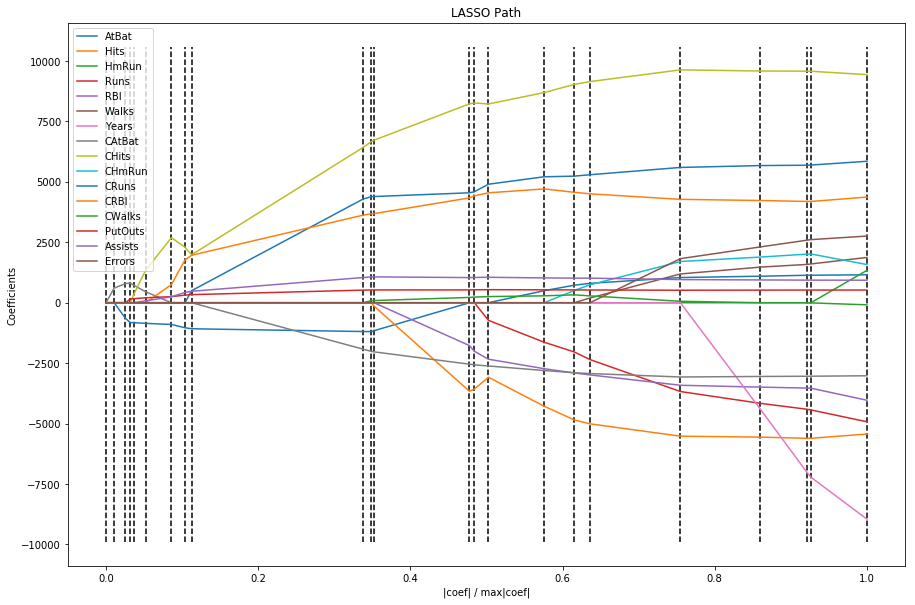

In [5]:
_, _, coefs = linear_model.lars_path(X, y.values.flatten(), method='lasso', verbose=True)

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.figure(figsize=(15, 10))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.legend(nameList)
plt.show()

In [6]:
#Create a list recording the first three predictors' weight that equal zero
indexOut = []

#Three top variables
for k in range(3):
    for i in range(len(nameList)):
        if (coefs[i][k+1] != 0 and i not in indexOut):
            indexOut.append(i)
            break
            
variable_topThree = [nameList[i] for i in indexOut]
print("Last three variables that remain in the LASSO regression model are:", variable_topThree)

Last three variables that remain in the LASSO regression model are: ['CAtBat', 'AtBat', 'PutOuts']


<H4>Use cross-validation to find the optimal value of the regularization penality</H4>

In [7]:
#List of parameters to choose from
alphasList = {'alpha': [1e-3, 1e-2, 1e-1, 1, 5, 10, 20, 100, 1e3]}
model_lasso = LassoCV(alphas = alphasList['alpha'], cv = 10).fit(X, y.values.flatten())
print('Best alpha for fitting LASSO regression model is:', model_lasso.alpha_)

Best alpha for fitting LASSO regression model is: 0.1


After running penalty parameter selection over values from $10^{−3}$  to 1000  over 10 corss validations, the best alpha for fitting thie LASSO regression model is 0.1. 

In [8]:
coef = pd.Series(model_lasso.coef_, index = X_col.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 11 variables and eliminated the other 5 variables


In [144]:
coef

AtBat       168.287901
Hits      -3552.817746
HmRun        -0.000000
Runs      -1134.031280
RBI       -2684.216017
Walks         0.000000
Years        -0.000000
CAtBat    -2888.519057
CHits      8279.057200
CHmRun        0.000000
CRuns      4954.442673
CRBI       4579.574489
CWalks      219.986420
PutOuts     401.974341
Assists     940.340085
Errors        0.000000
dtype: float64

From the table above, we can see at alpha = 0.1, the 11 variables selected by the model are: AtBat, Hits, Runs, RBI, CATBat, CHit, CRuns, CRBI, CWalks, PutOuts, Assists.

<H3>Ridge Regression</H3>

<H4>visualization of the coeffcient trajectories of all predictors</H4>

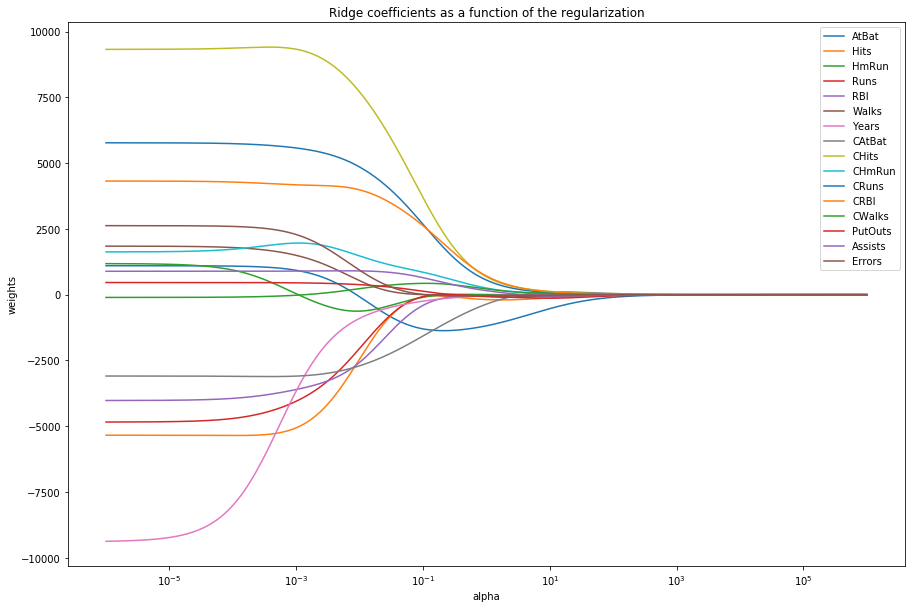

In [9]:
#Build Ridge Model
clf = Ridge()

#For a range of alpha from 10^e-3 to 10^e15
alphas = np.logspace(-6,6, 2000)
coefs = []

# Train the model with different regularisation strengths
for a in alphas:
    clf.set_params(alpha=a)
    clf.fit(X, y)
    coefs.append(clf.coef_.flatten())

# Display results for all 16 predictors (columns)
plt.figure(figsize=(15, 10))
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.legend(nameList)
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

<H4>Find the last three variables that remain in the model</H4>

In [10]:
#Create a list recording the alpha that single predictor's weight equals zero
alphaOut = []
for i in range(len(nameList)):
    for j in range(len(coefs)):
        if coefs[j][i] < 0.3 and coefs[j][i] > -0.3:
            alphaOut.append(j)
            break

#Get top 3 predictors that
index_topThree = sorted(range(len(alphaOut)), key=lambda i: alphaOut[i])[-3:]
variable_topThree = [nameList[i] for i in index_topThree] 
print("Last three variables that remain in the model are:", variable_topThree)
            

Last three variables that remain in the model are: ['Hits', 'CAtBat', 'AtBat']


<H4>Use cross-validation to find the optimal value of the regularization penality</H4>

In [11]:
ridge_cv = Ridge()
alphas = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20, 100, 1e3, 1e5, 1e8, 1e10]}
ridge_regression = GridSearchCV(ridge_cv, alphas, scoring='neg_mean_squared_error', cv = 10)
ridge_regression.fit(X,y)
print('The alpha for best fitting ridge regression model is:', ridge_regression.best_params_['alpha'])

The alpha for best fitting ridge regression model is: 0.01


/Users/byw/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


After running penalty parameter selection over values from $10^{-5}$ to $10^{10}$ over 10 corss validations, the best alpha for fitting thie ridge regression model is 0.01

In [21]:
#Find the weights of all variables at best alpha for ridge regression
clf = Ridge()
clf.set_params(alpha=0.01) #Best alpha in previous Cross-validation
clf.fit(X, y)

col_coef = clf.coef_.flatten()
col_name = nameList
df_coef = pd.DataFrame({'Variable' : col_name, 'Weight' : col_coef})
df_coef

,Variable,Weight
0,AtBat,-81.099802
1,Hits,-2445.090127
2,HmRun,-625.532580
3,Runs,-2039.563360
4,RBI,-2570.921261
5,Walks,529.121045
6,Years,-898.393883
7,CAtBat,-2703.043002
8,CHits,7706.266477
9,CHmRun,1472.592393


The table above shows the selected coeffecients for all 16 variables of ridge regression with best alpha chosen.

<H3>Short Answer</H3>

<br><b>Bias</b> in general means the discrepency between the predictive values to the actual ones whereas <b>Variance</b> is the differece of the results from same model with different training/validation sets.</br>
<br></br>
<br>The Bias-Varience Tradoff happends when the model is simplke and has few parameters, then it is not robust for dectecting minor changes to the data it fits, therefore the variance is low. However, its bias could be high given the model has low numbers of parameters to capture the features.</br>
<br>If the model is complex, it will likely to have high variance but less bias vice-versa since the model is highly variable and tend to overfit with specific training set.</br>
<img src="tradeoff.png" alt="Bias_Variance_Tradeoff">

<br><b>Regularization</b> is used to reduce the number of parameters for a given model. It will help reduce the variance at the cost of having higher bias.</br>
<br></br>
<br>For LASSO, the best fitting models reduce the number of predictors by setting the weights of them to zero, therefore it reduces the overall complexity to avoid having high varience, whereas ridge regression keeps all variables but adjusting their coffecient to mitigate the bias.</br>